In [1]:
import os
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

# Define the workdir path
workdir_path = "./workdir"

# Get all fold directories
fold_dirs = [os.path.join(workdir_path, d) for d in os.listdir(workdir_path) 
             if os.path.isdir(os.path.join(workdir_path, d)) and d.startswith("fold_")]
fold_dirs.sort()

print(f"Found {len(fold_dirs)} folds in {workdir_path}")
for fold_dir in fold_dirs:
    print(f"  - {os.path.basename(fold_dir)}")


Found 25 folds in ./workdir
  - fold_00
  - fold_01
  - fold_02
  - fold_03
  - fold_04
  - fold_05
  - fold_06
  - fold_07
  - fold_08
  - fold_09
  - fold_10
  - fold_11
  - fold_12
  - fold_13
  - fold_14
  - fold_15
  - fold_16
  - fold_17
  - fold_18
  - fold_19
  - fold_20
  - fold_21
  - fold_22
  - fold_23
  - fold_24


## Area Extraction

We'll use the same area extraction logic as in the model training pipeline.


In [2]:
# Area mapping must match the feeder and reader
AREA_REGEX = {
    "hundido": r"hundidocam\d+",
    "columpios": r"(columpios[_]?cam\d+|columpios_tierra)"
}

def get_area(name):
    """Extract area from clip name using regex patterns"""
    if re.search(AREA_REGEX["hundido"], name):
        return "hundido"
    if re.search(AREA_REGEX["columpios"], name):
        return "columpios"
    return "unknown"

area_to_id = {"hundido": 0, "columpios": 1, "unknown": 2}
id_to_area = {v: k for k, v in area_to_id.items()}


## Load and Analyze Fold Data

Let's load the data from each fold and analyze it.


In [3]:
# Initialize data structures to store analysis results
fold_stats = {}

# Process each fold
for fold_dir in fold_dirs:
    fold_name = os.path.basename(fold_dir)
    fold_stats[fold_name] = {
        'train': {'total_samples': 0, 'area_distribution': {}, 'class_distribution': {}},
        'eval': {'total_samples': 0, 'area_distribution': {}, 'class_distribution': {}}
    }
    
    # Process train data
    train_label_path = os.path.join(fold_dir, "train_label.pkl")
    if os.path.exists(train_label_path):
        with open(train_label_path, "rb") as f:
            train_labels = pickle.load(f)
        
        # Count total samples
        fold_stats[fold_name]['train']['total_samples'] = len(train_labels)
        
        # Extract areas and count distribution
        areas = [get_area(name) for _, name in train_labels]
        fold_stats[fold_name]['train']['area_distribution'] = dict(Counter(areas))
        
        # Extract class labels and count distribution
        classes = [int(label) for label, _ in train_labels]
        fold_stats[fold_name]['train']['class_distribution'] = dict(Counter(classes))
    
    # Process eval data
    eval_label_path = os.path.join(fold_dir, "eval_label.pkl")
    if os.path.exists(eval_label_path):
        with open(eval_label_path, "rb") as f:
            eval_labels = pickle.load(f)
        
        # Count total samples
        fold_stats[fold_name]['eval']['total_samples'] = len(eval_labels)
        
        # Extract areas and count distribution
        areas = [get_area(name) for _, name in eval_labels]
        fold_stats[fold_name]['eval']['area_distribution'] = dict(Counter(areas))
        
        # Extract class labels and count distribution
        classes = [int(label) for label, _ in eval_labels]
        fold_stats[fold_name]['eval']['class_distribution'] = dict(Counter(classes))


## Visualize Area Distribution Across Folds


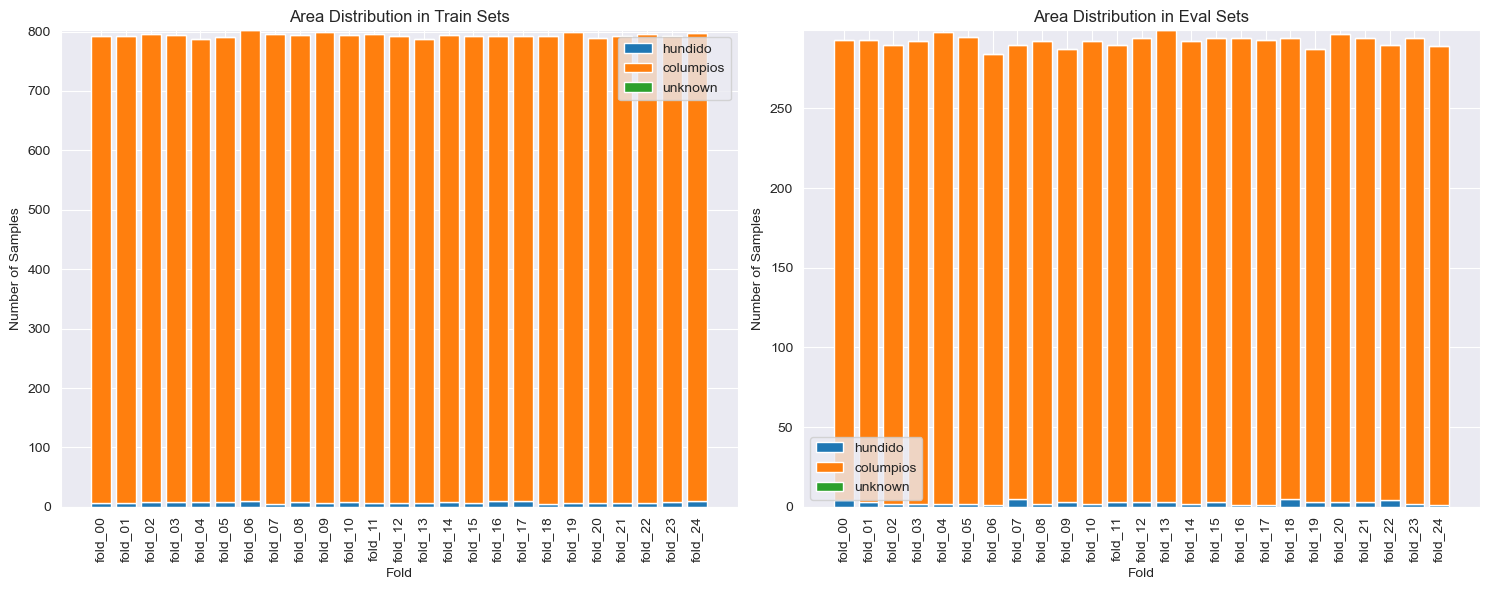

In [4]:
# Prepare data for visualization
train_area_counts = defaultdict(list)
eval_area_counts = defaultdict(list)
fold_names = []

for fold_name, stats in fold_stats.items():
    fold_names.append(fold_name)
    
    # Get area counts for train set
    train_areas = stats['train']['area_distribution']
    for area in ['hundido', 'columpios', 'unknown']:
        train_area_counts[area].append(train_areas.get(area, 0))
    
    # Get area counts for eval set
    eval_areas = stats['eval']['area_distribution']
    for area in ['hundido', 'columpios', 'unknown']:
        eval_area_counts[area].append(eval_areas.get(area, 0))

# Plot area distribution for train sets
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
bottom = np.zeros(len(fold_names))

for area in ['hundido', 'columpios', 'unknown']:
    plt.bar(fold_names, train_area_counts[area], bottom=bottom, label=area)
    bottom += np.array(train_area_counts[area])

plt.title('Area Distribution in Train Sets')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.legend()

# Plot area distribution for eval sets
plt.subplot(1, 2, 2)
bottom = np.zeros(len(fold_names))

for area in ['hundido', 'columpios', 'unknown']:
    plt.bar(fold_names, eval_area_counts[area], bottom=bottom, label=area)
    bottom += np.array(eval_area_counts[area])

plt.title('Area Distribution in Eval Sets')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


AREA DISTRIBUTION ANALYSIS
Analyzing 25 folds: fold_00, fold_01, fold_02, fold_03, fold_04, fold_05, fold_06, fold_07, fold_08, fold_09, fold_10, fold_11, fold_12, fold_13, fold_14, fold_15, fold_16, fold_17, fold_18, fold_19, fold_20, fold_21, fold_22, fold_23, fold_24

TRAINING SET TOTALS:
  Hundido: 185 samples
  Columpios: 19658 samples
  Unknown: 0 samples
  Total training samples: 19843

EVALUATION SET TOTALS:
  Hundido: 65 samples
  Columpios: 7242 samples
  Unknown: 0 samples
  Total evaluation samples: 7307

FOLD-BY-FOLD BREAKDOWN:

fold_00:
  Train: 793 samples (hundido:6, columpios:787)
  Eval:  293 samples (hundido:4, columpios:289)

fold_01:
  Train: 793 samples (hundido:7, columpios:786)
  Eval:  293 samples (hundido:3, columpios:290)

fold_02:
  Train: 796 samples (hundido:8, columpios:788)
  Eval:  290 samples (hundido:2, columpios:288)

fold_03:
  Train: 794 samples (hundido:8, columpios:786)
  Eval:  292 samples (hundido:2, columpios:290)

fold_04:
  Train: 788 sample

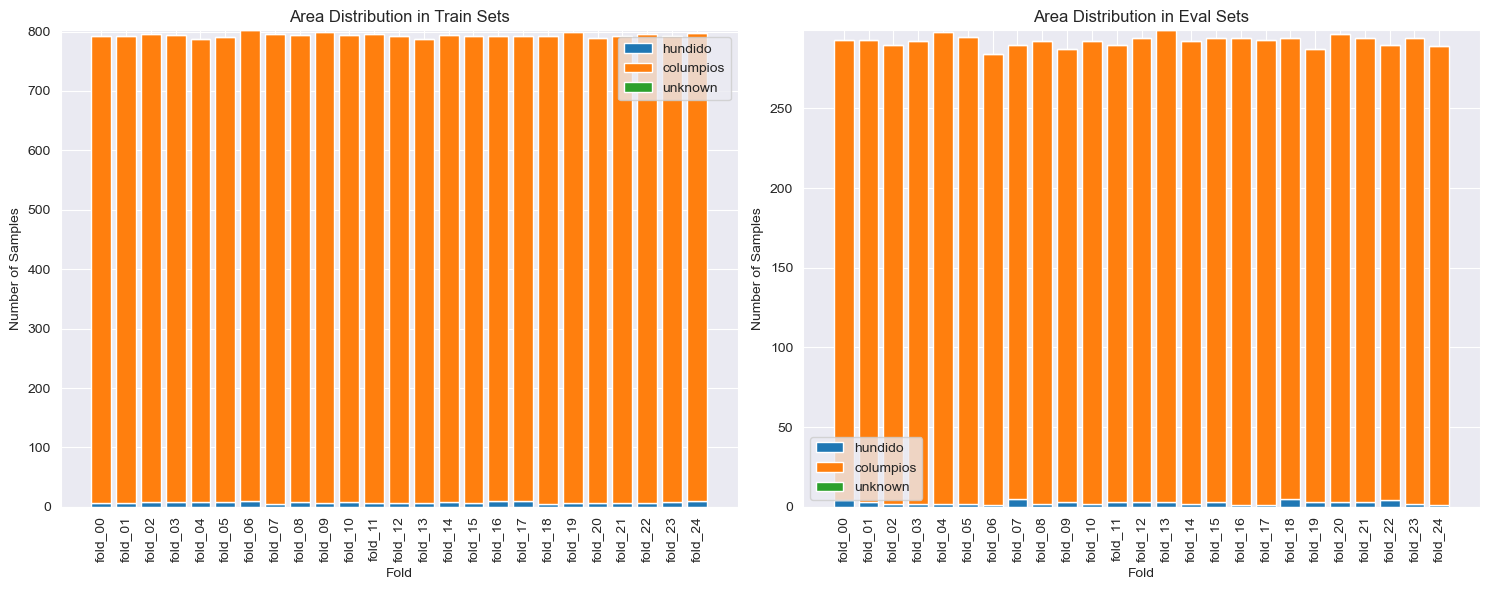

Visualization complete! Check the charts above for visual representation.


In [6]:
# Prepare data for visualization
train_area_counts = defaultdict(list)
eval_area_counts = defaultdict(list)
fold_names = []

for fold_name, stats in fold_stats.items():
    fold_names.append(fold_name)

    # Get area counts for train set
    train_areas = stats['train']['area_distribution']
    for area in ['hundido', 'columpios', 'unknown']:
        train_area_counts[area].append(train_areas.get(area, 0))

    # Get area counts for eval set
    eval_areas = stats['eval']['area_distribution']
    for area in ['hundido', 'columpios', 'unknown']:
        eval_area_counts[area].append(eval_areas.get(area, 0))

# Print verbal summary of area distribution
print("AREA DISTRIBUTION ANALYSIS")
print("=" * 50)
print(f"Analyzing {len(fold_names)} folds: {', '.join(fold_names)}")
print()

# Calculate totals for verbal summary
train_totals = {area: sum(counts) for area, counts in train_area_counts.items()}
eval_totals = {area: sum(counts) for area, counts in eval_area_counts.items()}

print("TRAINING SET TOTALS:")
for area in ['hundido', 'columpios', 'unknown']:
    print(f"  {area.capitalize()}: {train_totals[area]} samples")
print(f"  Total training samples: {sum(train_totals.values())}")

print("\nEVALUATION SET TOTALS:")
for area in ['hundido', 'columpios', 'unknown']:
    print(f"  {area.capitalize()}: {eval_totals[area]} samples")
print(f"  Total evaluation samples: {sum(eval_totals.values())}")

print("\nFOLD-BY-FOLD BREAKDOWN:")
for i, fold_name in enumerate(fold_names):
    train_total = sum(train_area_counts[area][i] for area in ['hundido', 'columpios', 'unknown'])
    eval_total = sum(eval_area_counts[area][i] for area in ['hundido', 'columpios', 'unknown'])

    print(f"\n{fold_name}:")
    print(f"  Train: {train_total} samples", end="")
    if train_total > 0:
        train_breakdown = [f"{area}:{train_area_counts[area][i]}" for area in ['hundido', 'columpios', 'unknown'] if train_area_counts[area][i] > 0]
        print(f" ({', '.join(train_breakdown)})")
    else:
        print()

    print(f"  Eval:  {eval_total} samples", end="")
    if eval_total > 0:
        eval_breakdown = [f"{area}:{eval_area_counts[area][i]}" for area in ['hundido', 'columpios', 'unknown'] if eval_area_counts[area][i] > 0]
        print(f" ({', '.join(eval_breakdown)})")
    else:
        print()

# Check for balance issues
print("\nBALANCE ANALYSIS:")
total_samples = sum(train_totals.values()) + sum(eval_totals.values())
for area in ['hundido', 'columpios', 'unknown']:
    area_total = train_totals[area] + eval_totals[area]
    percentage = (area_total / total_samples) * 100 if total_samples > 0 else 0
    print(f"  {area.capitalize()}: {area_total} samples ({percentage:.1f}% of total)")

if eval_totals['unknown'] > 0:
    print(f"\n⚠️  WARNING: Found {eval_totals['unknown']} 'unknown' area samples that may need attention")

print("\n" + "=" * 50)

# Plot area distribution for train sets
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
bottom = np.zeros(len(fold_names))

for area in ['hundido', 'columpios', 'unknown']:
    plt.bar(fold_names, train_area_counts[area], bottom=bottom, label=area)
    bottom += np.array(train_area_counts[area])

plt.title('Area Distribution in Train Sets')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.legend()

# Plot area distribution for eval sets
plt.subplot(1, 2, 2)
bottom = np.zeros(len(fold_names))

for area in ['hundido', 'columpios', 'unknown']:
    plt.bar(fold_names, eval_area_counts[area], bottom=bottom, label=area)
    bottom += np.array(eval_area_counts[area])

plt.title('Area Distribution in Eval Sets')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

print("Visualization complete! Check the charts above for visual representation.")

## Visualize Class Distribution Across Folds


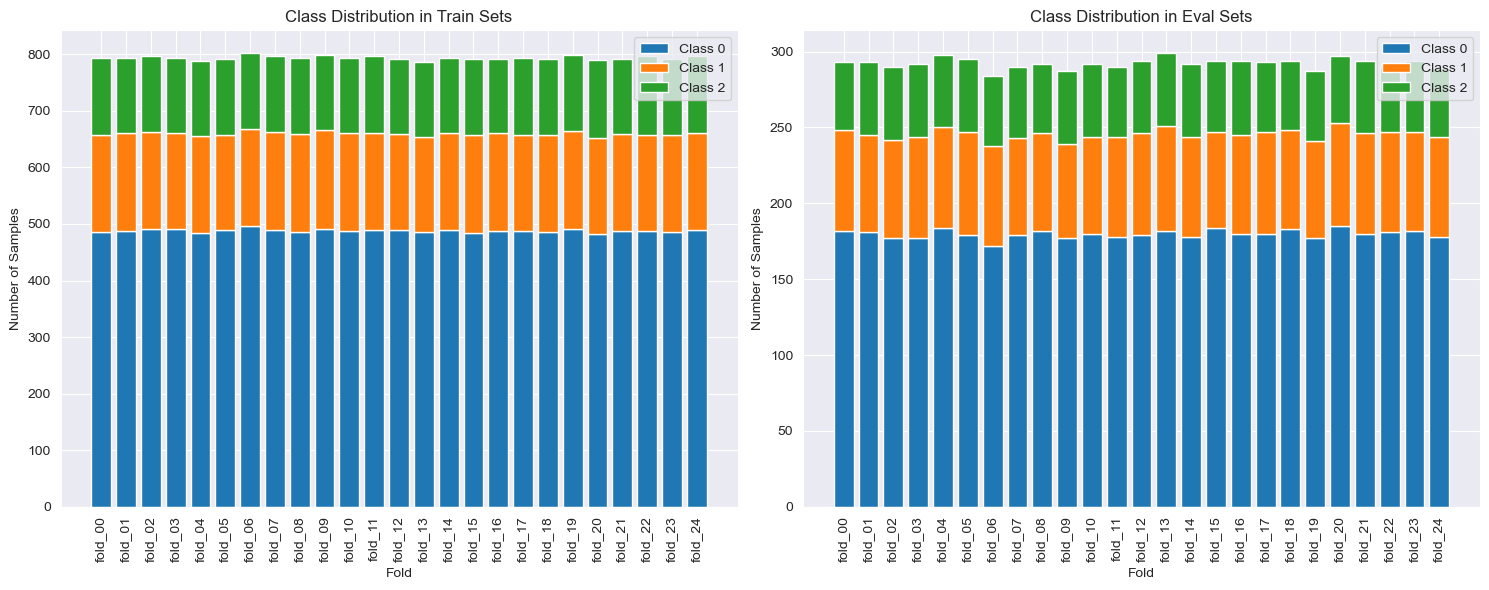

In [7]:
train_class_counts = defaultdict(list)
eval_class_counts = defaultdict(list)

# Find all unique classes
all_classes = set()
for stats in fold_stats.values():
    all_classes.update(stats['train']['class_distribution'].keys())
    all_classes.update(stats['eval']['class_distribution'].keys())
all_classes = sorted(all_classes)

# Get class counts for each fold
for fold_name, stats in fold_stats.items():
    # Get class counts for train set
    train_classes = stats['train']['class_distribution']
    for cls in all_classes:
        train_class_counts[cls].append(train_classes.get(cls, 0))
    
    # Get class counts for eval set
    eval_classes = stats['eval']['class_distribution']
    for cls in all_classes:
        eval_class_counts[cls].append(eval_classes.get(cls, 0))

# Plot class distribution for train sets
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
bottom = np.zeros(len(fold_names))

for cls in all_classes:
    plt.bar(fold_names, train_class_counts[cls], bottom=bottom, label=f'Class {cls}')
    bottom += np.array(train_class_counts[cls])

plt.title('Class Distribution in Train Sets')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.legend()

# Plot class distribution for eval sets
plt.subplot(1, 2, 2)
bottom = np.zeros(len(fold_names))

for cls in all_classes:
    plt.bar(fold_names, eval_class_counts[cls], bottom=bottom, label=f'Class {cls}')
    bottom += np.array(eval_class_counts[cls])

plt.title('Class Distribution in Eval Sets')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


## Sample Counts Summary


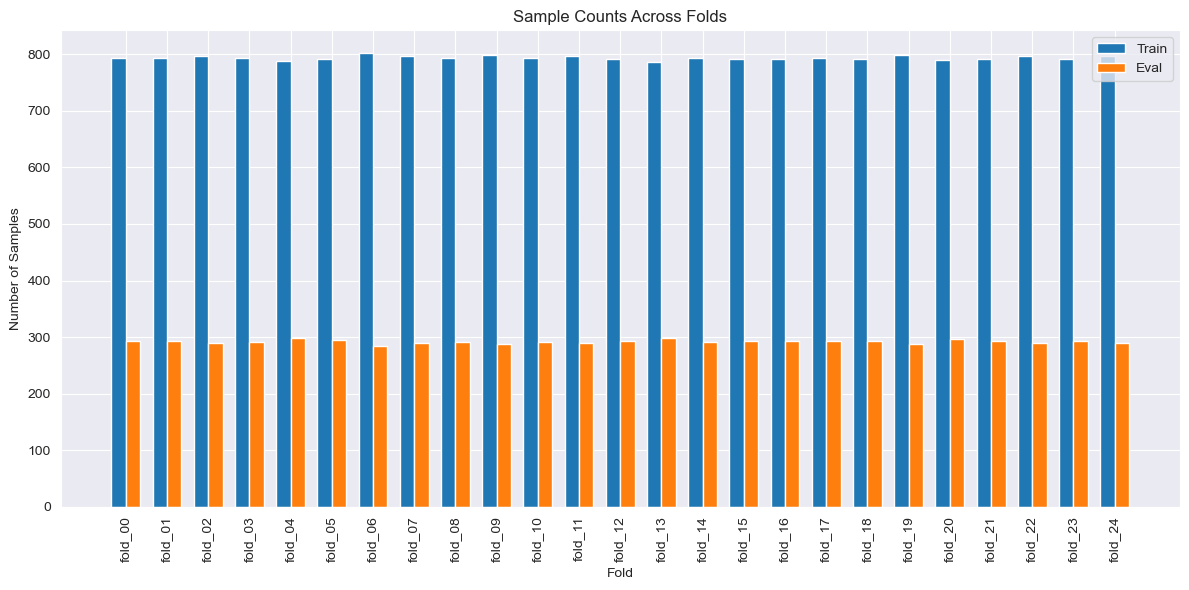

In [8]:
# Prepare data for visualization
train_samples = [stats['train']['total_samples'] for stats in fold_stats.values()]
eval_samples = [stats['eval']['total_samples'] for stats in fold_stats.values()]

# Plot sample counts
plt.figure(figsize=(12, 6))
x = np.arange(len(fold_names))
width = 0.35

plt.bar(x - width/2, train_samples, width, label='Train')
plt.bar(x + width/2, eval_samples, width, label='Eval')

plt.title('Sample Counts Across Folds')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.xticks(x, fold_names, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


## Content Analysis

Let's analyze what content is inside each fold by looking at the object data.


In [9]:
# Initialize data structures for content analysis
object_data_stats = defaultdict(lambda: defaultdict(list))

# Process each fold
for fold_dir in fold_dirs:
    fold_name = os.path.basename(fold_dir)
    
    # Process train object data
    train_obj_path = os.path.join(fold_dir, "train_object_data.npy")
    if os.path.exists(train_obj_path):
        train_obj_data = np.load(train_obj_path)
        
        # Get shape and basic stats
        object_data_stats[fold_name]['train_shape'] = train_obj_data.shape
        object_data_stats[fold_name]['train_mean'] = np.mean(train_obj_data)
        object_data_stats[fold_name]['train_std'] = np.std(train_obj_data)
        object_data_stats[fold_name]['train_min'] = np.min(train_obj_data)
        object_data_stats[fold_name]['train_max'] = np.max(train_obj_data)
    
    # Process eval object data
    eval_obj_path = os.path.join(fold_dir, "eval_object_data.npy")
    if os.path.exists(eval_obj_path):
        eval_obj_data = np.load(eval_obj_path)
        
        # Get shape and basic stats
        object_data_stats[fold_name]['eval_shape'] = eval_obj_data.shape
        object_data_stats[fold_name]['eval_mean'] = np.mean(eval_obj_data)
        object_data_stats[fold_name]['eval_std'] = np.std(eval_obj_data)
        object_data_stats[fold_name]['eval_min'] = np.min(eval_obj_data)
        object_data_stats[fold_name]['eval_max'] = np.max(eval_obj_data)

# Display content analysis results
print("Content Analysis Results:")
for fold_name, stats in object_data_stats.items():
    print(f"\n{fold_name}:")
    print(f"  Train Object Data:")
    print(f"    Shape: {stats['train_shape']}")
    print(f"    Mean: {stats['train_mean']:.4f}")
    print(f"    Std: {stats['train_std']:.4f}")
    print(f"    Min: {stats['train_min']:.4f}")
    print(f"    Max: {stats['train_max']:.4f}")
    
    print(f"  Eval Object Data:")
    print(f"    Shape: {stats['eval_shape']}")
    print(f"    Mean: {stats['eval_mean']:.4f}")
    print(f"    Std: {stats['eval_std']:.4f}")
    print(f"    Min: {stats['eval_min']:.4f}")
    print(f"    Max: {stats['eval_max']:.4f}")


Content Analysis Results:

fold_00:
  Train Object Data:
    Shape: (793, 48, 4, 3)
    Mean: 0.0038
    Std: 0.0505
    Min: 0.0000
    Max: 0.9937
  Eval Object Data:
    Shape: (293, 48, 4, 3)
    Mean: 0.0045
    Std: 0.0551
    Min: 0.0000
    Max: 0.9812

fold_01:
  Train Object Data:
    Shape: (793, 48, 4, 3)
    Mean: 0.0039
    Std: 0.0505
    Min: 0.0000
    Max: 0.9937
  Eval Object Data:
    Shape: (293, 48, 4, 3)
    Mean: 0.0043
    Std: 0.0552
    Min: 0.0000
    Max: 0.9847

fold_02:
  Train Object Data:
    Shape: (796, 48, 4, 3)
    Mean: 0.0044
    Std: 0.0549
    Min: 0.0000
    Max: 0.9847
  Eval Object Data:
    Shape: (290, 48, 4, 3)
    Mean: 0.0028
    Std: 0.0422
    Min: 0.0000
    Max: 0.9937

fold_03:
  Train Object Data:
    Shape: (794, 48, 4, 3)
    Mean: 0.0039
    Std: 0.0513
    Min: 0.0000
    Max: 0.9937
  Eval Object Data:
    Shape: (292, 48, 4, 3)
    Mean: 0.0043
    Std: 0.0532
    Min: 0.0000
    Max: 0.9797

fold_04:
  Train Object Data:
   